import some packages that's we need

In [125]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

draw something

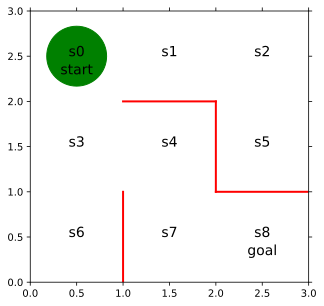

In [126]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

plt.plot([1,1],[0,1],color='red',linewidth=2)
plt.plot([1,2],[2,2],color='red',linewidth=2)
plt.plot([2,2],[2,1],color='red',linewidth=2)
plt.plot([2,3],[1,1],color='red',linewidth=2)

plt.text( .5,2.5,'s0',size=14,ha='center')
plt.text(1.5,2.5,'s1',size=14,ha='center')
plt.text(2.5,2.5,'s2',size=14,ha='center')
plt.text( .5,1.5,'s3',size=14,ha='center')
plt.text(1.5,1.5,'s4',size=14,ha='center')
plt.text(2.5,1.5,'s5',size=14,ha='center')
plt.text( .5, .5,'s6',size=14,ha='center')
plt.text(1.5, .5,'s7',size=14,ha='center')
plt.text(2.5, .5,'s8',size=14,ha='center')
plt.text( .5,2.3,'start',size=14,ha='center')
plt.text(2.5, .3,'goal',size=14,ha='center')

ax.set_xlim(0,3)
ax.set_ylim(0,3)
plt.tick_params(axis='both',which='both',bottom='off',top='off',
                labelbottom='off',left='off',right='off',labelleft='off')

line, = ax.plot([ .5],[2.5],marker='o',color='g',markersize=60)

In [127]:
theta_0 = np.array([[np.nan, 1, 1, np.nan], # s0
                    [np.nan, 1, np.nan, 1], # s1
                    [np.nan, np.nan, 1, 1], # s2
                    [1     , 1, 1, np.nan], #s3
                    [np.nan, np.nan, 1, 1], #s4
                    [1, np.nan, np.nan, np.nan], # s5
                    [1, np.nan, np.nan, np.nan], # s6
                    [1, 1, np.nan, np.nan], # s7
                   ])

In [128]:
def simple_convert_into_pi_from_theta(theta):
    [m,n] = theta.shape
    pi = np.zeros((m,n))
    for i in range(0,m):
        pi[i,:] = theta[i,:]/np.nansum(theta[i,:])
    pi = np.nan_to_num(pi)
    return pi
pi_0 = simple_convert_into_pi_from_theta(theta_0)    
print(pi_0)

[[0.    0.5   0.5   0.   ]
 [0.    0.5   0.    0.5  ]
 [0.    0.    0.5   0.5  ]
 [0.333 0.333 0.333 0.   ]
 [0.    0.    0.5   0.5  ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.5   0.5   0.    0.   ]]


In [129]:
def get_next_s(pi, s):
    direction = {
        'up': -3,
        'right': 1,
        'down': 3,
        'left': -1
    }
    next_direction = np.random.choice([i for i in direction.keys()], p=pi[s,:])
    return s + direction[next_direction]

def goal_maze(pi):
    s = 0
    state_history = [0]
    while True:
        next_s = get_next_s(pi,s)
        state_history.append(next_s)
        if next_s == 8:
            break
        else:
            s = next_s
    return state_history
state_history = goal_maze(pi_0)
print(state_history)

[0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 3, 0, 3, 0, 1, 0, 1, 0, 3, 6, 3, 4, 7, 8]


In [130]:
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)
def animate(i):
    state = state_history[i]
    x = (state % 3) + .5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line,)
anim = animation.FuncAnimation(fig, animate,init_func=init, 
                              frames=len(state_history),interval=300, repeat=False)
HTML(anim.to_jshtml())

In [131]:
def softmax_convert_into_pi_from_theta(theta):
    beta = 1.0
    [m,n] = theta.shape
    pi = np.zeros((m,n))
    exp_theta = np.exp(beta * theta)
    for i in range(0,m):
        pi[i,:] = exp_theta[i,:] / np.nansum(exp_theta[i,:])
    pi = np.nan_to_num(pi)
    return pi
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[0.    0.5   0.5   0.   ]
 [0.    0.5   0.    0.5  ]
 [0.    0.    0.5   0.5  ]
 [0.333 0.333 0.333 0.   ]
 [0.    0.    0.5   0.5  ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.5   0.5   0.    0.   ]]


In [132]:
def get_action_and_next_s(pi, s):
    dire = {
        'up': [0, -3],
        'right':[1, 1],
        'down': [2, 3],
        'left': [3, -1]
    }
    next_dire = np.random.choice([i for i in dire.keys()], p=pi[s,:])
    return [dire[next_dire][0],s + dire[next_dire][1]]

def goal_maze_ret_s_a(pi):
    s = 0
    s_a_history = [[0, np.nan]]
    while True:
        [act, next_s] = get_action_and_next_s(pi,s)
        s_a_history[-1][1] = act
        s_a_history.append([next_s, np.nan])
        if next_s == 8:
            break
        else:
            s = next_s
    return s_a_history

s_a_history = goal_maze_ret_s_a(pi_0)

In [133]:

# 策略迭代法
def update_theta(theta, pi, s_a_history):
    # 学习率
    eta = .1
    # 到达目标的总步数 
    T = len(s_a_history) - 1
    [m,n] = theta.shape
    delta_theta = theta.copy()
    for i in range(0,m):
        for j in range(0,n):
            if not(np.isnan(theta[i,j])):
                SA_i = [SA for SA in s_a_history if SA[0] == i]
                SA_ij = [SA for SA in s_a_history if SA == [i,j]]
                N_i,N_ij = len(SA_i),len(SA_ij)
                delta_theta[i,j] = (N_ij - pi[i,j] * N_i) /T
    new_theta = theta + eta * delta_theta
    return new_theta

new_theta = update_theta(theta_0,pi_0,s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi)

[[0.    0.501 0.499 0.   ]
 [0.    0.5   0.    0.5  ]
 [0.    0.    0.501 0.499]
 [0.334 0.333 0.333 0.   ]
 [0.    0.    0.5   0.5  ]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.501 0.499 0.    0.   ]]


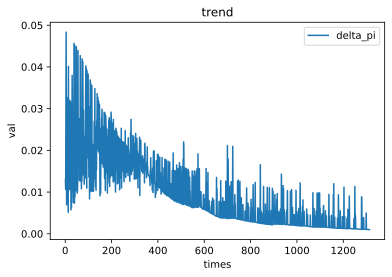

In [134]:
stop_epsilon = 10**-3
theta,pi = theta_0,pi_0
is_continue,count = True,1
x,y,z = [],[],[]
while is_continue:
    s_a_history = goal_maze_ret_s_a(pi)
    new_theta = update_theta(theta,pi,s_a_history)
    new_pi = softmax_convert_into_pi_from_theta(new_theta)
    # 调试
    x.append(count)
    y.append(np.sum(np.abs(new_pi-pi)))
    z.append(len(s_a_history) - 1)
    count += 1
#     print(np.sum(np.abs(new_pi-pi)))
    # print("total steps to resolve maze: ", len(s_a_history) - 1)
    if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi

# plt.plot(x, z, label='steps')  # Plot some data on the (implicit) axes.
plt.plot(x, y, label='delta_pi')
plt.xlabel('times')
plt.ylabel('val')
plt.title("trend")
plt.legend();

In [135]:
np.set_printoptions(precision=3,suppress=True)
print(pi)
print(s_a_history)

[[0.    0.046 0.954 0.   ]
 [0.    0.357 0.    0.643]
 [0.    0.    0.447 0.553]
 [0.034 0.928 0.037 0.   ]
 [0.    0.    0.948 0.052]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.044 0.956 0.    0.   ]]
[[0, 2], [3, 1], [4, 2], [7, 1], [8, nan]]


In [136]:
def animate(i):
    state = s_a_history[i][0]
    x = (state % 3) + .5
    y = 2.5 - int(state / 3)
    line.set_data(x, y)
    return (line,)
anim = animation.FuncAnimation(fig, animate,init_func=init, 
                              frames=len(s_a_history),interval=200, repeat=False)
HTML(anim.to_jshtml())